# BARPA

- __BARPA__:
    - Project ia39 (soon moving to py18)
        - /g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/\<gcm\>/\<experiment\>/\<realisation\>/BOM-BARPA-R/v1/\<freq\>/\<variable\>
        - 8 gcms, 6 frequencies, 183 variables
    - https://github.com/AusClimateService/BARPA-data-release/blob/main
    - BARPA is a downscaling method for future projections
        - BARPA-R is regional (17 km) model
        - BARPA-C is city scale (~1 km) and not as easily available?
    - 44TB per ssp folder
    FFDI:
        - UAS+VAS is 10m winds
        - HURS is near surface (1.5m) relative humidity
        - TAS is near surface atmos temp
        - PS surface air pressure

In [1]:
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import importlib

## Put us in the right repo for local relative pathing
import os
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric/"
os.chdir(__repo__)
import plotting, fio


In [2]:
from dask.distributed import Client
client = Client()
#display(client.proxy)
print(client.dashboard_link)

/proxy/8787/status


In [3]:
gcms = [
    ## evaluation/historical only
    "ECMWF-ERA5",
    "MPI-M-MPI-ESM1-2-HR", 
    ## with ssp projections:
    "CMCC-CMCC-ESM2",
    "CSIRO-ACCESS-ESM1-5",
    "CSIRO-ARCCSS-ACCESS-CM2", 
    "EC-Earth-Consortium-EC-Earth3",
    "NCAR-CESM2","CSIRO-ACCESS-ESM1-5",
    "NCC-NorESM2-MM",
    ]
experiments = [
    "evaluation", # 1979-2020
    "historical", # 1960-2014
    "ssp126", # 2015-2100
    "ssp370", # 2015-2100
    ]

gcm = gcms[2]
experiment = "ssp370"
realisation = "r1i1p1f1"
freq = "1hr"
var = "uas"

## eg: 
##     g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/ECMWF-ERA5/evaluation/r1i1p1f1/BOM-BARPA-R/v1/day/uas/
url_barpa_folder_base = "/g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/%s/%s/%s/BOM-BARPA-R/v1/%s/%s/"
url_barpa_folder = url_barpa_folder_base%(gcm,experiment,realisation,freq,var)

In [4]:
print(url_barpa_folder)
url_barpa_varfiles = glob(url_barpa_folder+"*.nc")
url_barpa_varfiles.sort()
print("  - Contains %d netcdfs"%len(url_barpa_varfiles))
print("  - from: ",url_barpa_varfiles[0].split('/')[-1])
print("  - to:   ",url_barpa_varfiles[-1].split('/')[-1])

/g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/CMCC-CMCC-ESM2/ssp370/r1i1p1f1/BOM-BARPA-R/v1/1hr/uas/
  - Contains 86 netcdfs
  - from:  uas_AUS-15_CMCC-CMCC-ESM2_ssp370_r1i1p1f1_BOM-BARPA-R_v1_1hr_201501-201512.nc
  - to:    uas_AUS-15_CMCC-CMCC-ESM2_ssp370_r1i1p1f1_BOM-BARPA-R_v1_1hr_210001-210012.nc


In [5]:
barpa_uas = xr.open_mfdataset(url_barpa_varfiles)


/g/data/en0/jwg574/repos/extra_pip_libs/lib/python3.9/site-packages/ecmwflibs/__init__.py:83: UserWarning: No module named 'ecmwflibs._ecmwflibs'
  warnings.warn(str(e))


In [6]:
print(barpa_uas.dims)
print(barpa_uas.height)
print(barpa_uas.height.values)

Frozen({'time': 753360, 'lat': 436, 'lon': 777})
<xarray.DataArray 'height' ()>
array(10.)
Coordinates:
    height   float64 10.0
Attributes:
    standard_name:  height
    units:          m
    positive:       up
    long_name:      height
10.0


# Read year of BARPA
1. Read variables (optionally set gcm, experiment, etc...)
2. calculate FFDI
    - Requires Dewpoint Temperature

In [18]:
barpa = fio.BARPA_read_year(vars=['hurs','tas','ps','uas','vas'], year=2035)

INFO: reading from  /g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/CMCC-CMCC-ESM2/ssp370/r1i1p1f1/BOM-BARPA-R/v1/1hr/hurs/hurs_AUS-15_CMCC-CMCC-ESM2_ssp370_r1i1p1f1_BOM-BARPA-R_v1_1hr_203501-203512.nc
INFO: reading from  /g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/CMCC-CMCC-ESM2/ssp370/r1i1p1f1/BOM-BARPA-R/v1/1hr/tas/tas_AUS-15_CMCC-CMCC-ESM2_ssp370_r1i1p1f1_BOM-BARPA-R_v1_1hr_203501-203512.nc
INFO: reading from  /g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/CMCC-CMCC-ESM2/ssp370/r1i1p1f1/BOM-BARPA-R/v1/1hr/ps/ps_AUS-15_CMCC-CMCC-ESM2_ssp370_r1i1p1f1_BOM-BARPA-R_v1_1hr_203501-203512.nc
INFO: reading from  /g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/CMCC-CMCC-ESM2/ssp370/r1i1p1f1/BOM-BARPA-R/v1/1hr/uas/uas_AUS-15_CMCC-CMCC-ESM2_ssp370_r1i1p1f1_BOM-BARPA-R_v1_1hr_203501-203512.nc
INFO: reading from  /g/data/ia39/australian-climate-service/release/CORDEX-C

In [19]:
importlib.reload(fio)
barpa = fio.calc_Td(barpa,t='tas',rh='hurs')
barpa = fio.calc_DWI_V(barpa,d2m='Td',t2m='tas',u10='uas',v10='vas')
barpa = fio.calc_ffdi(barpa,d2m='Td',t2m='tas',u10='uas',v10='vas')

In [20]:
print(barpa['hurs'].height,barpa['vas'].height)

1.5 10.0


Coordinates:
  * time     (time) object 2035-01-01 00:00:00 ... 2035-12-31 23:00:00
  * lat      (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
s10 ('time', 'lat', 'lon')
0  nans in each time slice


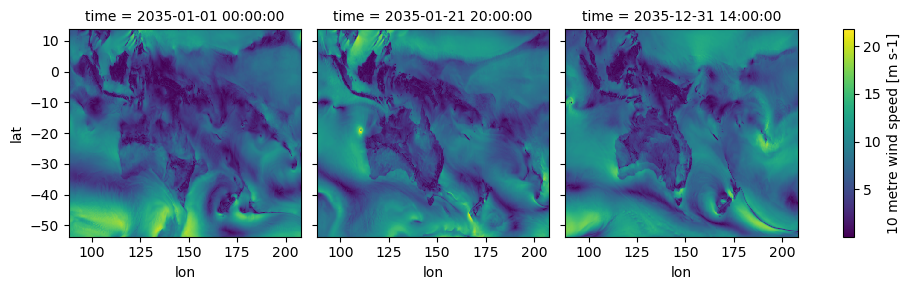

Td ('time', 'lat', 'lon')
0  nans in each time slice


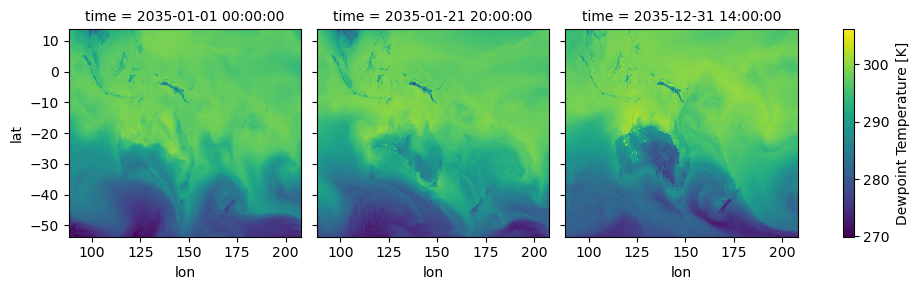

DWI_V ('time', 'lat', 'lon')
0  nans in each time slice


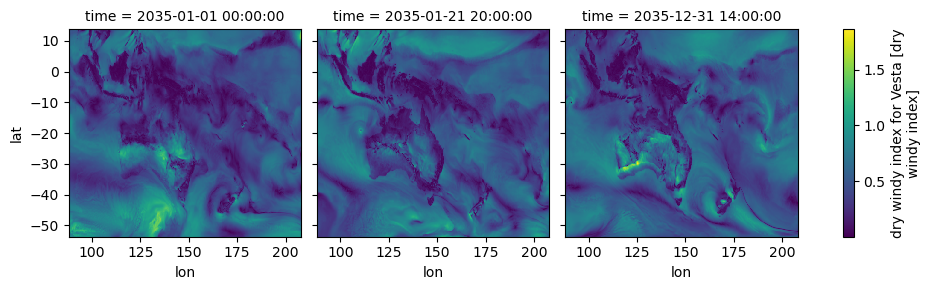

FFDI ('time', 'lat', 'lon')
0  nans in each time slice


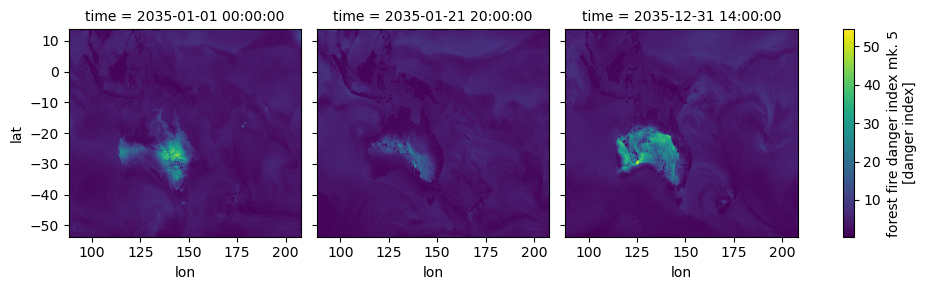

In [21]:
print(barpa['hurs'].coords)
for var in ['s10','Td','DWI_V','FFDI']:#'hurs','tas','ps','uas','vas',
    print(var, barpa[var].dims)
    icheck = [0,500,-10]
    print(np.sum(np.isnan(barpa[var].isel(time=0).values)), ' nans in each time slice')
    barpa[var].isel(time=icheck).plot(col='time')
    plt.show()

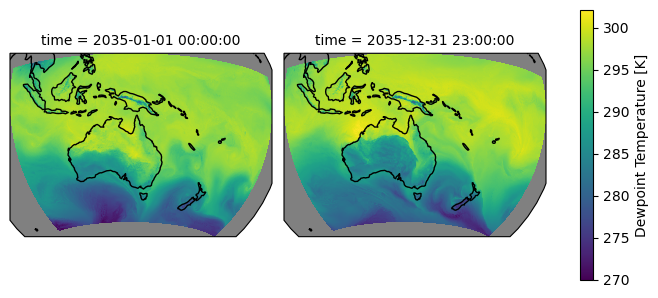

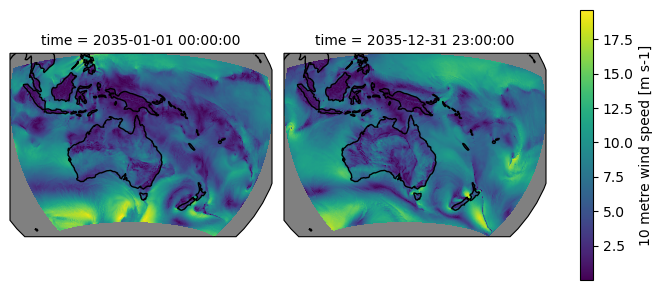

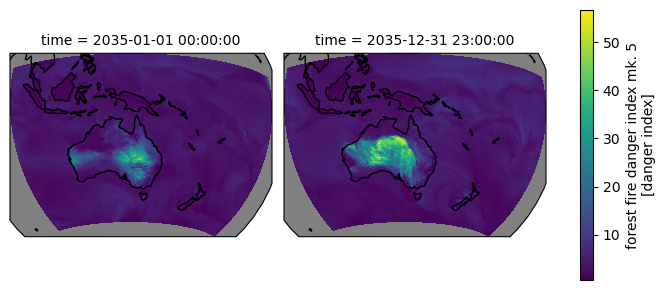

In [57]:
plotting.plot_quick(barpa['Td'],itimes=[0,-1])
plt.show()
plotting.plot_quick(barpa['s10'],itimes=[0,-1])
plt.show()
plotting.plot_quick(barpa['FFDI'],itimes=[0,-1])
plt.show()

# Produce yearly FFDI files of daily maximums

1. Read model data
3. calculate FFDI, DWI_V, FFDI_F
4. save yearly maximum values to intermediate

- This takes a few hours and 100 GB RAM per decade
- edit "make_all_BARPA_dailymax.sh" and run it to get whole century quickly
    - runs make_BARPA_daily_max.sh over 15 years in separate processes

In [7]:
importlib.reload(fio)
    

<module 'fio' from '/g/data/en0/jwg574/repos/climate_fire/fio.py'>

# Read subset of daily maximums


In [4]:
from fio import BARPA_read_intermediate_years


In [5]:

ds_20s_370 = BARPA_read_intermediate_years("202*")
ds_30s_370 = BARPA_read_intermediate_years("203*")
ds_40s_370 = BARPA_read_intermediate_years("204*")
ds_50s_370 = BARPA_read_intermediate_years("205*")
ds_90s_370 = BARPA_read_intermediate_years("209*")
#ds_20s_126 = BARPA_read_intermediate_years("202*",experiment='ssp126')


INFO: Reading 10 BARPA dailymax files matching year 202*


/g/data/en0/jwg574/repos/extra_pip_libs/lib/python3.9/site-packages/ecmwflibs/__init__.py:83: UserWarning: No module named 'ecmwflibs._ecmwflibs'
  warnings.warn(str(e))


INFO: Reading 10 BARPA dailymax files matching year 203*
INFO: Reading 10 BARPA dailymax files matching year 204*
INFO: Reading 10 BARPA dailymax files matching year 205*
INFO: Reading 10 BARPA dailymax files matching year 209*


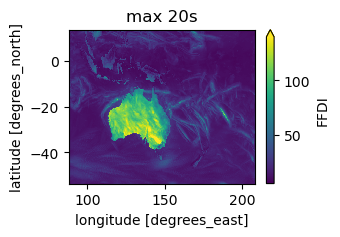

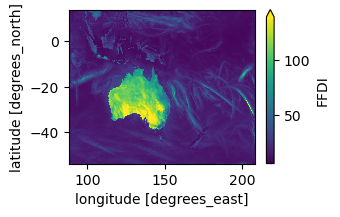

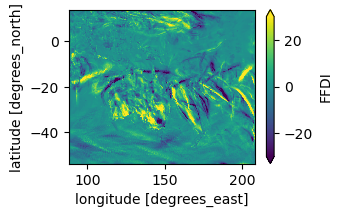

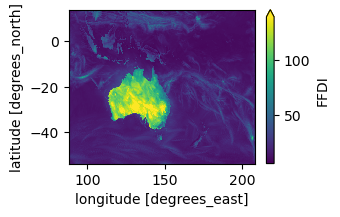

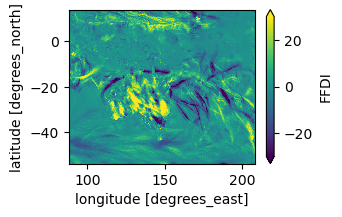

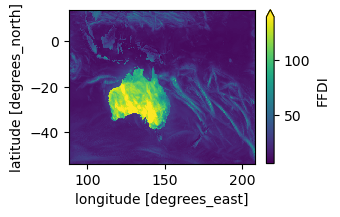

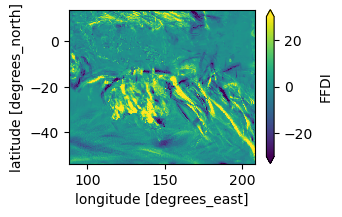

In [31]:
plt.rcParams['figure.figsize'] = [3, 2]
mean_20s=ds_20s_370.FFDI.max(dim='time')
mean_20s.plot(vmax=140)
plt.title("max 20s")
plt.show()
for ds in [ds_30s_370,ds_50s_370,ds_90s_370,]:
    #plt.figure(figsize=[5,4])
    mean_ds = ds.FFDI.max(dim='time')
    mean_ds.plot(vmax=140)
    plt.show()
    (mean_ds-mean_20s).plot(vmin=-30,vmax=30)
    plt.show()

# Time series looking at Capital cities
1. show gcm/scenario FFDI,DWI_V time series for various cities
    - try daily/monthly/yearly
    - maybe there's a way to do spread from the GCMs?
2. add ERA5 as historical time series

In [6]:
latlons = { # "loc" : [lat,lon]
    "Melbourne Airport":{
        "latlon":[-37.6722, 144.8503],
        "ilatlon":[103,368],
    },
    "Adelaide Hills":{
        "latlon":[-34.9063, 138.8397],
        "ilatlon":[121,329],
    },
    "Sydney West":{
        "latlon":[-33.8, 150.7],
        "ilatlon":[128,406],
    },
}

In [32]:
## Get index matching location
# A 2D plot of the SPEED variable, assigning the coordinate values,
# and plot the verticies of each point
## Test with one time step
ds_20s_370 = fio.BARPA_read_intermediate_years("202*")
ds = ds_20s_370.FFDI[0]

for (name,deets) in latlons.items():
    lat,lon = deets['latlon']
    abslat = np.abs(ds.lat-lat)
    abslon = np.abs(ds.lon-lon)
    c = np.maximum(abslon, abslat)
    ([xloc], [yloc]) = np.where(c == np.min(c))

    print(name,lat,lon)
    print("    ilat, ilon:", yloc,xloc)
    print("    model lat,lon:", ds.lat.values[yloc],ds.lon.values[xloc])


Melbourne Airport -37.6722 144.8503
    ilat, ilon: 103 368
    model lat,lon: -37.662 144.89149
Adelaide Hills -34.9063 138.8397
    ilat, ilon: 121 329
    model lat,lon: -34.881 138.866
Sydney West -33.8 150.7
    ilat, ilon: 128 406
    model lat,lon: -33.7995 150.7625


In [4]:
importlib.reload(fio)
ds_cmcc = fio.BARPA_read_intermediate_years("2*")
ds_cmcc_hist = fio.BARPA_read_intermediate_years("*",experiment='historical')

INFO: Reading 86 BARPA dailymax files matching year 2*


/g/data/en0/jwg574/repos/extra_pip_libs/lib/python3.9/site-packages/ecmwflibs/__init__.py:83: UserWarning: No module named 'ecmwflibs._ecmwflibs'
  warnings.warn(str(e))


INFO: Reading 55 BARPA dailymax files matching year *


In [10]:
#ds_cmcc.FFDI # time,lat,lon
places = ['Melbourne Airport',"Adelaide Hills","Sydney West"]
colors = ['yellow','magenta','red']
ds_ts = {}
for place in places:
    ilat,ilon = latlons[place]['ilatlon']
    # resample monthly max
    ds_ts[place] = xr.merge([ds_cmcc.FFDI[:,ilat,ilon],ds_cmcc_hist.FFDI[:,ilat,ilon]]).load()
    

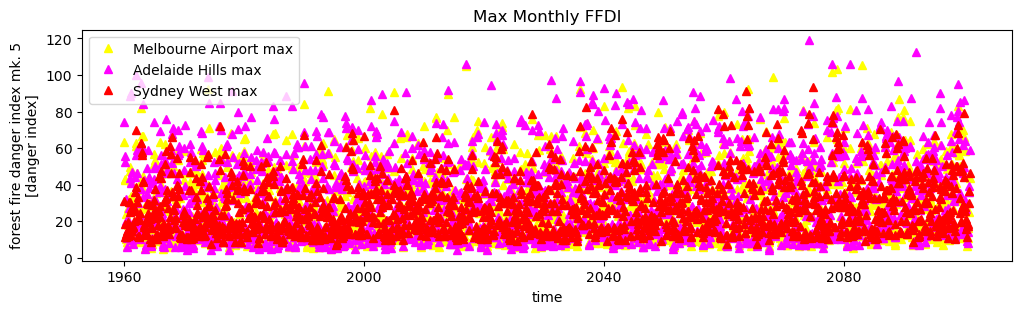

In [14]:
plt.figure(figsize=[12,3])
for place,color in zip(places,colors):
    # figsize = (aspect * size, size)
    ds_ts[place].FFDI.resample(time='M').max().plot.line('^',color=color, label=place+' max')
    #print(ds_ts[place].resample(time='M').max())
    #ds_ts[place].resample(time='M').quantile(0.75).plot.line('-',color=color, label=place+' q=.75')
plt.title('Max Monthly FFDI')
plt.legend()
#plt.show()

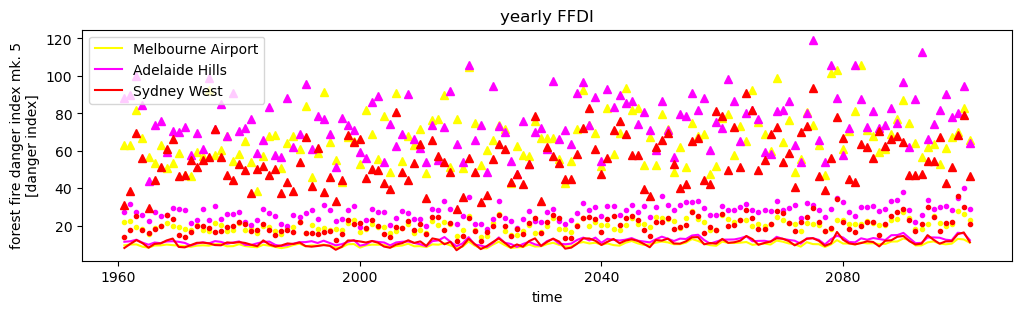

In [15]:
plt.figure(figsize=[12,3])
for place,color in zip(places,colors):
    
    ds_ts[place].FFDI.resample(time='Y').max().plot.line('^',color=color,)#label=place+' max')
    ds_ts[place].FFDI.resample(time='Y').quantile(0.9).plot.line('.',color=color,)# label=place+' q=.75')
    ds_ts[place].FFDI.resample(time='Y').mean().plot.line('-',color=color, label=place)
    
plt.title('yearly FFDI')
plt.legend()
#plt.show()

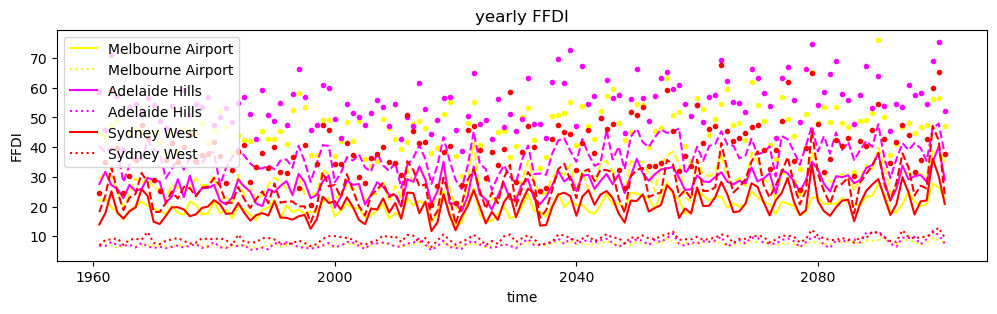

In [16]:
plt.figure(figsize=[12,3])
for place,color in zip(places,colors):
    
    #ds_ts[place].resample(time='Y').max().plot.line('^',color=color,)#label=place+' max')
    ds_ts[place].FFDI.resample(time='Y').quantile(0.99).plot.line('.',color=color,)# label=place+' q=.75')
    ds_ts[place].FFDI.resample(time='Y').quantile(0.95).plot.line('--',color=color,)# label=place+' q=.75')
    ds_ts[place].FFDI.resample(time='Y').quantile(0.90).plot.line('-',color=color, label=place)
    ds_ts[place].FFDI.resample(time='Y').quantile(0.50).plot.line(':',color=color, label=place)
    
plt.title('yearly FFDI')
plt.legend()
#plt.show()

# Read those daily maximums, save into one file

In [27]:
%%time 
## just for 5 years:  20 seconds ~ 6GB Ram
## for 25 years: 
## all those daily maximums
url_to_save = fio.BARPA_daily_max_folder + fio.BARPA_intermediate_url("ALL",gcm,experiment,realisation)

ds_all = BARPA_read_intermediate_years("20[123]*")

ds_all.to_netcdf(url_to_save)

INFO: Reading 25 BARPA dailymax files matching year 20[123]*
CPU times: user 26.5 s, sys: 17.4 s, total: 43.9 s
Wall time: 4min 39s


In [11]:
ds_all = xr.open_mfdataset(url_to_save)


In [12]:
print(ds_all)

<xarray.Dataset>
Dimensions:  (lat: 436, lon: 777, time: 1825)
Coordinates:
  * lat      (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
  * time     (time) object 2015-01-01 00:00:00 ... 2019-12-31 00:00:00
Data variables:
    FFDI     (time, lat, lon) float32 dask.array<chunksize=(1825, 436, 777), meta=np.ndarray>
    DWI_V    (time, lat, lon) float32 dask.array<chunksize=(1825, 436, 777), meta=np.ndarray>
    FFDI_F   (time, lat, lon) float32 dask.array<chunksize=(1825, 436, 777), meta=np.ndarray>
